# 2. EcoToxicity Classification Model for Chemical Compounds based on IR-specrta


-----

In [2]:
#libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#ML
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler

#xgb
import xgboost as xgb

#utils for visualisation
import scienceplots

SEED = 42

plt.style.use(["science", "no-latex"])
plt.rcParams["font.family"] = "Times New Roman"

## 2.1 Read data with Ecotox dataset

In [6]:
ecotox = pd.read_excel(os.path.join('..', 'data', 'envirotox_20240201154635.xlsx'))
# here we will use only EC50 parameter and test duration equal 4 days
ecotox = ecotox[(ecotox['Test statistic'] == 'EC50') & (ecotox['Duration (days)'] == 4)]

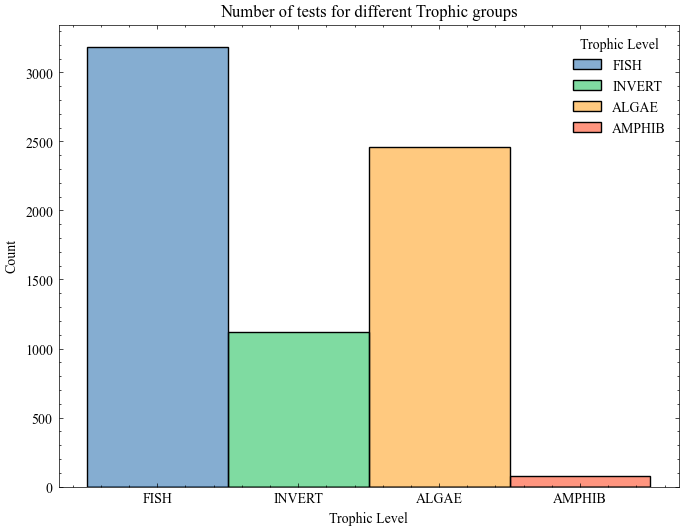

In [7]:
plt.figure(figsize=(8,6))
sns.histplot(data=ecotox, x='Trophic Level', hue='Trophic Level')
plt.title('Number of tests for different Trophic groups')
# plt.savefig('../plots/barplot_trophic.png', dpi=300)
plt.show()

## 2.2 Read data with IR-spectra dataset

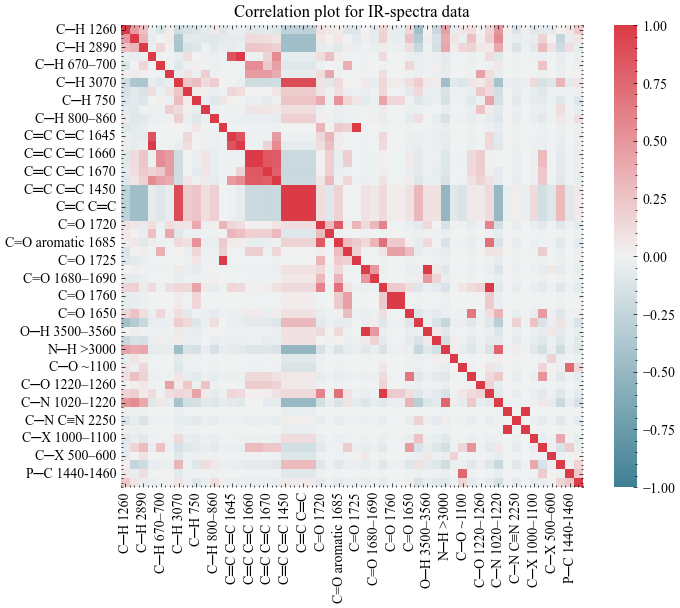

In [8]:

def get_data(correlation_level: float = 0.75, plot_corr: bool = False):
    flags = pd.read_csv(os.path.join('..', 'data', 'EC50_flags_short_names.csv'))
    flags = flags.drop(columns='Unnamed: 0')

    mask = flags['Trophic Level']=='ALGAE'
    flags = flags.loc[mask]
    tox_list = []
    for i,row in flags.iterrows():
        if row['Effect value'] >= 100:
            tox_list.append(0)
        else:
            tox_list.append(1) 
    flags.insert(0, 'tox_flag', tox_list)
    
    X = flags.iloc[:, 26:]
    
    cols_same_values = []
    for col in X.columns:
        if X[col].nunique()==1:
            cols_same_values.append(col)
            
    X = X.drop(columns=cols_same_values)
    y = flags['tox_flag']
    corr = X.corr()
    if plot_corr:
        f, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(corr,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin=-1.0, vmax=1.0,
            square=True, ax=ax)
        ax.set_title('Correlation plot for IR-spectra data')
    
    # Select upper triangle of correlation matrix
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    
    # Find features with correlation greater than correlation_level
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_level)]
    
    column_list = [i for i in X.columns if '─' in i]
    drop_list = []
    for i in column_list:
        if X[i].sum() == 0:
            drop_list.append(i)
    X = X.drop(drop_list, axis=1)
    X = X.drop(to_drop, axis=1)
    return X, y


X, y = get_data(correlation_level=0.75, plot_corr=True)

## 2.3 Modelling - model selection and hyper-parameter optimization

In [19]:

def init_models():
    return { 
        "kNN": KNeighborsClassifier(n_jobs=6), 
        "SVC": SVC(),
        "RandomForest": RandomForestClassifier(bootstrap=True, n_jobs=6, random_state=SEED), 
        "XGB": xgb.XGBClassifier(n_jobs=6, random_state=SEED)}

def get_random_forest():
    n_estimators = np.arange(100,200,20)
    max_depth = np.arange(10,110,11)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    random_grid = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}
    return {"grid":random_grid}

def get_svm():
    svc_grid = {'C': [0.01, 0.1, 10,100], 
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf', 'linear', 'poly']
             }
    return {"grid":svc_grid}
def get_KNN():
    metric = ['euclidean','manhattan','chebyshev','minkowski']
    n_neighbors = np.arange(4,15,2)
    weights = ['uniform','distance']
    random_grid_knn = {'n_neighbors': n_neighbors,
        'weights': weights,
        'metric': metric}
    return {"grid":random_grid_knn}

def get_XGB():
    params = { 'max_depth': [3,6,10],
           "min_child_weight": [0.5, 1, 2],
           'n_estimators': np.arange(10,80,20),
           'colsample_bytree': [0.3, 0.7, 1]}
    return {"grid":params}

models = {
    'RandomForest': get_random_forest(), 
     "SVC":get_svm(),
    "kNN":get_KNN(),
    "XGB":get_XGB()}

__Example of training simple model without cross-validation__

In [10]:
# Load dataset with removing correlated columns 
X, y = get_data()

# Split initial dataset into 70:30 proportion for train/test parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

ros = RandomUnderSampler(sampling_strategy=0.5, random_state=SEED)
X_train, y_train = ros.fit_resample(X_train,y_train)
print('Shape data after RandomUnderSampler', y_train.value_counts())

# kNN model
knn = KNeighborsClassifier(n_neighbors=5)

# train model
knn.fit(X_train, y_train)

# test prediction
predictions = knn.predict(X_test)

# Metrics and confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
f1 = f1_score(y_test, predictions, average='weighted')
accuracy = accuracy_score(y_test, predictions, )
balanced_accuracy = metrics.balanced_accuracy_score(y_test, predictions)
print()
print(f"Confusion Matrix:\nTrue positive: {conf_matrix[1,1]}\nTrue Negative: {conf_matrix[0,0]}\nFalse Negative: {conf_matrix[1,0]}\nFalse Negative: {conf_matrix[0,1]}")
print()
print("F1 Score: ", round(f1,2))
print("Accuracy Balanced: ", round(balanced_accuracy, 2))


Shape data after RandomUnderSampler tox_flag
1    150
0     75
Name: count, dtype: int64

Confusion Matrix:
True positive: 228
True Negative: 20
False Negative: 108
False Negative: 8

F1 Score:  0.76
Accuracy Balanced:  0.7


__Model comparing with number or runs and RandomizedSearchCV__

In [20]:

best_models = {}
container = []

for i in range(15): 
    print(i, end=' ')
    for model_name, param_grid in models.items():
        model = init_models()[model_name]
        gs = RandomizedSearchCV(estimator=model,
                        param_distributions = param_grid['grid'],
                        n_iter = 10,
                        cv = 4,
                        scoring= 'f1', 
                        verbose=0,
                       n_jobs = 5)
    
    
        gs.fit(X_train, y_train)
        y_pred = gs.best_estimator_.predict(X_test)
        model_fit = gs.best_estimator_
        best_models[model_name] =  model_fit
        f1 = f1_score(y_test, y_pred,average='weighted')
        recall = metrics.recall_score(y_test, y_pred, average='weighted')
        container.append({'iter':i, 'model': model_name, 'f1_score': f1, 'recall': recall})

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 

## 2.4 Save model metrics and plot results as barplot

In [21]:
df_metrics = pd.DataFrame(container)
df_metrics.groupby(['model']).mean()

,iter,f1_score,recall
model,,,
RandomForest,7.0,0.824213,0.775092
SVC,7.0,0.836841,0.793407
XGB,7.0,0.831302,0.787729
kNN,7.0,0.787759,0.723993


In [22]:
df_metrics.groupby(['model']).std()

,iter,f1_score,recall
model,,,
RandomForest,4.472136,0.017223,0.024569
SVC,4.472136,0.008456,0.011665
XGB,4.472136,0.007166,0.010304
kNN,4.472136,0.002946,0.004004


In [24]:
df_metrics.to_csv('../data/metrics.csv', index=False)

In [25]:
df_metrics = pd.read_csv('../data/metrics.csv')

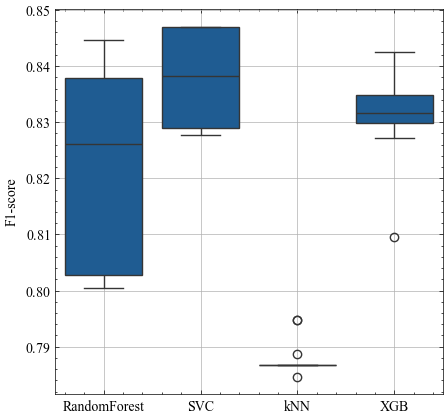

In [26]:
fig, ax1 = plt.subplots(1,1, figsize=(5,5))
sns.boxplot(data=df_metrics, 
            y='f1_score',
            x='model', 
            ax=ax1)
ax1.set_ylabel('F1-score')
ax1.set_xlabel('')
ax1.grid()
fig.savefig('../plots/F1-scores.png', dpi=300)
fig.savefig('../plots/F1-scores.pdf')

## 2.5 Feature importance with SHAP

In [12]:
import shap

shap.initjs()


In [13]:
model = best_models['RandomForest']
explainer = shap.Explainer(model)
shap_values = explainer(X)

/Users/mikhailgasanov/geo/lib/python3.12/site-packages/matplotlib/ticker.py:2918: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


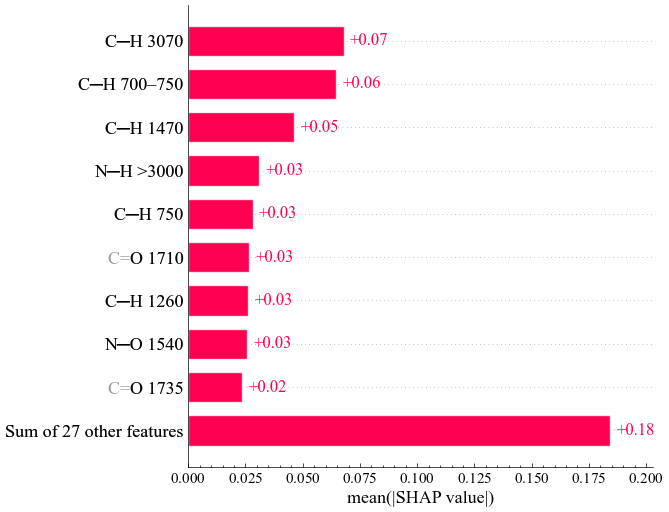

In [16]:
fig, ax1 = plt.subplots(1,1, figsize=(6,6))
ax1 = shap.plots.bar(shap_values[:, :, 1], ax=ax1, show_data=False)
fig.savefig('../plots/SHAP.pdf', dpi=300)

## End